# *TP1 - DEEP LEARNING*

# Partie 2 : _Implémentation avec Pytorch_

### 2.1 Forward et backward manuels
On va commencer par coder le réseau de neurones en utilisant simplement les opérations mathématiques de base et en transcrivant donc directement nos équations mathématiques. On utilisera les fonctions que l’on trouve dans le package `torch`.

#### Importations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

#### Chargement des données

In [2]:
# charger les utilitaires de générations et visualisation des données
from utilitaires import *

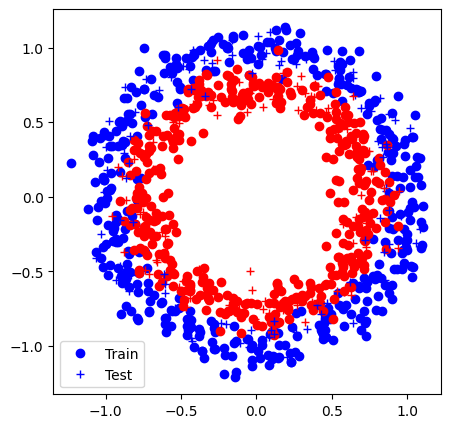

In [3]:
# préparer et visualiser le jeux de données
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
plot_data(data)

**1. Écrire la fonction `init_params(nx, nh, ny)` qui initialise les poids d'un réseau à partir des tailles nx, nh et ny et les sauvegarde dans un dictionnaire. Tous les poids seront initialisés selon une loi normale de moyenne 0 et d'écart-type 0.3.**


In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: des nombres entiers
    out params: dictionnaire des paramètres
    """
    params = {}

    moyenne = 0
    ecart_type = 0.3
    
    #####################
    ## Votre code ici  ##
    #####################
    # remplir avec les paramètres Wh, Wy, bh, by
    params["Wh"] = np.random.normal(loc=moyenne, scale=ecart_type, size=(nh, nx))
    params["Wy"] = np.random.normal(loc=moyenne, scale=ecart_type, size=(ny, nh))
    params["bh"] = np.zeros((nh,))
    params["by"] = np.zeros((ny,))

    return params


**2. Écrire la fonction `forward(params, X)` qui calcule les étapes intermédiaires et la sortie du réseau à partir d’un batch d’entrée X et des poids stockés dans params et les stocke dans un dictionnaire. On retourne le dictionnaire des  ́etapes intermédiaires et la sortie Ŷ du réseau.**


In [ ]:
def forward(params, X):
    """
    - In    :
    params  : dictionnaire des parametres
    X       : batch d'entrée (n_batch, dimension)
    - Out   :
    yhat    : sortie du réseau Ŷ (prédiction)
    outputs : dictionnaire des étapes intermédiaires et la sortie Ŷ du réseau.
    """
    
    outputs = {}

    #####################
    ## Votre code ici  ##
    ##################### 
    # remplir avec les paramètres X, htilde, h, ytilde, yhat

    Wh = params["Wh"]   # (nh, nx)
    Wy = params["Wy"]   # (ny, nh)
    bh = params["bh"]   # (nh,)
    by = params["by"]   # (ny,)

    outputs["X"] = X
    # htilde = X @ Wh.T + bh
    htilde = X.dot(Wh.T) + bh  # (batch, nh)
    # activation: tanh (derivable)
    h = np.tanh(htilde)        # (batch, nh)
    # ytilde = h @ Wy.T + by
    ytilde = h.dot(Wy.T) + by  # (batch, ny)

    # softmax row-wise (stabilité numérique)
    ytilde_stable = ytilde - np.max(ytilde, axis=1, keepdims=True)
    exp_scores = np.exp(ytilde_stable)
    yhat = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    outputs["htilde"] = htilde
    outputs["h"] = h
    outputs["ytilde"] = ytilde
    outputs["yhat"] = yhat

    return outputs['yhat'], outputs

**3. Écrire la fonction  `loss_accuracy(Yhat, Y)` qui calcule la fonction de coût et la précision (taux de
bonnes prédictions) à partir d’une matrice de sortie Ŷ (sortie de forward ) vis-à-vis d’une matrice de ground-truth Y de même taille, et retourne la loss L et la précision acc .**

In [ ]:
def loss_accuracy(Yhat, Y):
    """
    - In    :
    Yhat    :
    Y       :
    - Out   :
    L       :
    acc     :
    """
    
    L = acc = 0
    #####################
    ## Votre code ici  ##
    #####################
    eps = 1e-12
    # ensure float arrays
    Yhat = np.asarray(Yhat, dtype=float)
    Y = np.asarray(Y, dtype=float)

    # loss: average negative log-likelihood
    # pick only terms where Y==1
    # general: - sum(Y * log(Yhat)) / batch
    batch = Y.shape[0]
    L = - np.sum(Y * np.log(Yhat + eps)) / batch

    # accuracy: percentage of correct argmax
    preds = np.argmax(Yhat, axis=1)
    truths = np.argmax(Y, axis=1)
    acc = 100.0 * np.mean(preds == truths)
    return L, acc

**4. Écrire la fonction `backward(params, outputs, Y)` qui calcule les gradients du loss par rapport
aux paramètres et les sauvegarde dans un dictionnaire.**


In [ ]:
def backward(params, outputs, Y):
    """
    - In    :
    params  :
    outputs :
    Y       :
    - Out   :
    grads   :
    """
    
    bsize = Y.shape[0]
    grads = {}

    # Étapes :   
    # Initialisation des gradients à zéro
    # Calcul du gradient de la couche de sortie
    # Calcul du gradient de la couche cachée

    #####################
    ## Votre code ici  ##
    #####################
    # remplir avec les paramètres Wy, Wh, by, bh

    Wh = params["Wh"]   # (nh, nx)
    Wy = params["Wy"]   # (ny, nh)

    X = outputs["X"]            # (b, nx)
    h = outputs["h"]            # (b, nh)
    htilde = outputs["htilde"]  # (b, nh)
    yhat = outputs["yhat"]      # (b, ny)

    # gradient of loss w.r.t ytilde (softmax + cross-entropy)
    # dL/dytilde = (yhat - Y) / batch
    dytilde = (yhat - Y) / bsize   # (b, ny)

    # grads Wy: (ny, nh) = dytilde^T @ h
    grads["Wy"] = dytilde.T.dot(h)   # (ny, nh)
    # grads by: (ny,) = sum over batch
    grads["by"] = np.sum(dytilde, axis=0)  # (ny,)

    # backprop into hidden: dh = dytilde @ Wy
    dh = dytilde.dot(Wy)   # (b, nh)

    # derivative of tanh: 1 - tanh^2(htilde) = 1 - h^2
    dhtilde = dh * (1.0 - h**2)   # (b, nh)

    # grads Wh: (nh, nx) = dhtilde^T @ X
    grads["Wh"] = dhtilde.T.dot(X)   # (nh, nx)
    # grads bh: (nh,) = sum over batch
    grads["bh"] = np.sum(dhtilde, axis=0)  # (nh,)
    
    return grads

**5. Écrire la fonction `sgd(params, grads, eta)` qui applique une descente de gradient stochastique par mini-batch et met à jour les paramètres du réseau à partir de leurs gradients et du pas d’apprentissage.**

In [ ]:
def sgd(params, grads, eta):
    """
    - In    :
    params  :
    gards   :
    eta     :
    - Out   :
    params  :
    """

    #####################
    ## Votre code ici  ##
    #####################
    # mettre à jour les params

    params["Wh"] = params["Wh"] - eta * grads["Wh"]
    params["Wy"] = params["Wy"] - eta * grads["Wy"]
    params["bh"] = params["bh"] - eta * grads["bh"]
    params["by"] = params["by"] - eta * grads["by"]

    return params

**6. Application : Mettre en oeuvre l’algorithme global d’apprentissage en utilisant les fonctions précédentes.**



In [ ]:
#initialisation des params
eta = 0.03
params = init_params(nx, nh, ny)

# epoch
curves = [[], [], [], [], [], []]
for iteration in range(200):

    # permutations
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #initialisation loss et acc par bacth
    Loss=[]
    Acc=[]

    for j in range(N // Nbatch):
        
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        #####################
        ## Votre code ici  ##
        #####################
        # écrire l'algorithme d'apprentissage sur le batch (X,Y)
        # en utilisant les fonctions forward, loss_accuracy, backward, sgd

        Yhat, outputs = forward(params, X)
        loss, acc = loss_accuracy(Yhat, Y)
        grads = backward(params, outputs, Y)
        params = sgd(params, grads, eta)

        Loss.append(loss)
        Acc.append(acc)
    
    # accummulation de la loss et des accuracy par batch  
    LBatch = sum(Loss)/len(Loss)
    accBatch = sum(Acc)/len(Acc)
    
    # ou bien calculer sur la dataset d'entrainement entière
    Yhat_train, _ = forward(params, data.Xtrain)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)

    Yhat_test, _ = forward(params, data.Xtest)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    
    if iteration % 20 == 0 :
        title = f'\n Iter {iteration}: Acc. train {acctrain:.1f}% ({Ltrain:.2f}), Acc. test {acctest:.1f}% ({Ltest:.2f})'
        Ygrid, _ = forward(params, data.Xgrid)
        plot_data_with_grid(data,Ygrid, title)

    curves[0].append(accBatch)
    curves[1].append(acctrain)
    curves[2].append(acctest)

    curves[3].append(LBatch)
    curves[4].append(Ltrain)
    curves[5].append(Ltest)

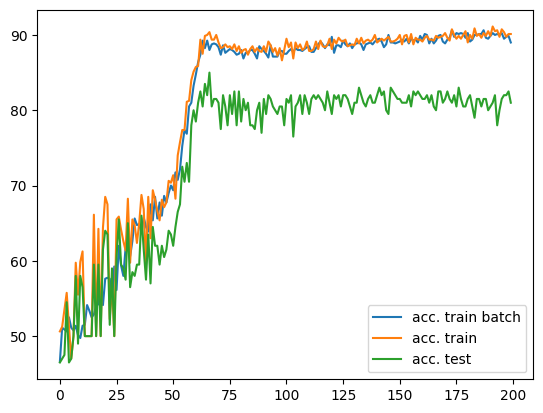

In [10]:
fig = plt.figure()
plt.plot(curves[0], label="acc. train batch")
plt.plot(curves[1], label="acc. train")
plt.plot(curves[2], label="acc. test")
plt.legend()
plt.show()

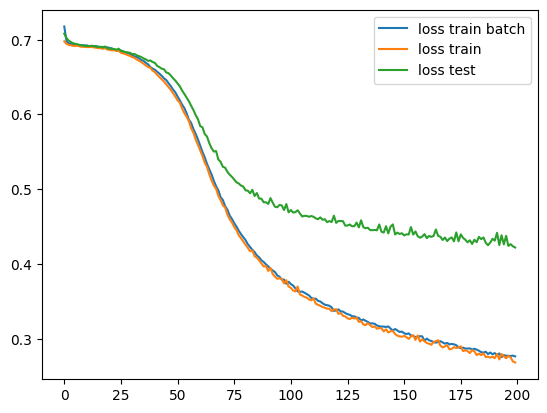

In [11]:
fig = plt.figure()
plt.plot(curves[3], label="loss train batch")
plt.plot(curves[4], label="loss train")
plt.plot(curves[5], label="loss test")

plt.legend()
plt.show()